In [9]:
# some standard python imports #

import numpy as np
from numpy import inf
import pandas as pd
import math
from astropy.stats import sigma_clipped_stats
from scipy.spatial import KDTree
from scipy.stats import bootstrap

import matplotlib
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt

import illustris_python as il
import MAS_library as MASL
import smoothing_library as SL
import h5py 
import yt
import caesar
import readgadget
from readgadget import readsnap
import scienceplots

In [10]:
plt.style.use('science')

In [11]:
def inttopair(n, num_columns):
    row = n // num_columns
    col = n % num_columns
    return row, col

In [12]:
def sorter(high,low,arr):
    basear=arr[0]
    idx=np.where((basear>low) & (basear<high))[0]
    sortar=[]
    for i in arr:
        tempar=i[idx]
        sortar.append(tempar)
    return sortar

In [13]:
def second(arr):
    unique_elements = list(set(arr))
    unique_elements.sort()
    second=unique_elements[1]
    return second

In [14]:
def deltamaker(pos,size):
    
    
    grid = size+1                         #this is how you specify the size of your density grid (I just made it 100x100)
    MAS      = 'CIC'                   #Cloud-in-Cell. This is just the interpolation scheme we are using to calculate the density
    BoxSize = size                       #from simulation params. Mpc/h 
    R = 4                              #smoothing kernal in Mpc/h
    Filter  = 'Top-Hat'                #type of smoothing kernal 
    threads = 8                        #computer threads, for parallelization 

    
    #Get density field.  MASL.MA is filling in the values of delta_g using CIC interpolation
    delta = np.zeros((grid,grid,grid), dtype=np.float32)
    MASL.MA(pos, delta, BoxSize, MAS, verbose=False)
    delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0

    # smooth the field
    W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)
    delta_smoothed = SL.field_smoothing(delta, W_k, threads)

    return delta_smoothed

In [15]:
def envmaker(pos):
    kdtree=KDTree(pos)
    env,points=kdtree.query(pos,3)
    env_list=np.array([np.log10(i[2]) for i in env])

    return env_list

In [16]:
def stdfunc(data):
    if len(data)>20000:
        temp_std=0
    else:
        a,b,temp_std=sigma_clipped_stats(temp_bias)
    return temp_std

In [17]:
def binmaker(par,bin_num,pos,snap_del,group_del):
    sortar=[par,pos]
    
    par_max=np.max(par)
    par_min=np.min(par)

    bins=np.linspace(par_min,par_max,bin_num+1)
    med_bin=[]
    med_bias=[]
    med_err=[]
    bias_std=[]
    std_err=[]
    for i in range(bin_num):
        low=bins[i]
        high=bins[i+1]
        temp_med_bin=round(((low+high)/2),2)
        med_bin.append(temp_med_bin)
        
        sort=sorter(bins[i+1],bins[i],sortar)
        temp_pos=np.array(np.rint(sort[1]),dtype=int)
        temp_group_delta=np.array([group_del[x,y,z] for x, y, z in temp_pos])
        temp_snap_delta=np.array([snap_del[x,y,z] for x, y, z in temp_pos])
        temp_bias=(temp_group_delta/temp_snap_delta)
        
        temp_mean_bias,temp_med_bias,temp_bias_std=sigma_clipped_stats(temp_bias)
        temp_med_err=temp_bias_std/np.sqrt(len(temp_bias))
        temp_std_err=bootstrap((temp_bias,), np.std, n_resamples=150).standard_error
        
        med_bias.append(temp_med_bias)
        med_err.append(temp_med_err)
        bias_std.append(temp_bias_std)
        std_err.append(temp_std_err)
        #import pdb; pdb.set_trace()

    
    return med_bin,med_bias,med_err,bias_std,std_err

In [18]:
def my_SMF(Mgal,numbins,box_size):
    '''
    Calculate stellar mass function (or luminosity function)
    ----
    Mgal: galaxy masses (or magnitudes)
    numbins: number of bins
    box_size: volume of simulation - length on one side in e.g. Mpc/h
    -----
    myphi: in units of box_size^(-1)/M
    ----
    '''
    hist, bins = np.histogram(Mgal, numbins)
    dx = bins[1:]-bins[:-1]
    myM = (bins[:-1]+bins[1:])/2.0
    myphi = hist/dx/box_size**3

    sig = np.sqrt(hist)/dx/box_size**3

    return myM , myphi, sig

In [19]:
def SMBmaker(tempPath1,tempPath2,temp_box,h,k_max,k_min):
    #TNG Bias and parameter maker
    #Snap
    snap_pos = np.array(readgadget.read_block(tempPath1, "POS ", [1])/1e3,dtype=np.float32) #positions in Mpc/h
    snap_del=deltamaker(snap_pos,temp_box)

    #Group
    group=caesar.load(tempPath2)
    group_pos=np.array([i.pos.to('Mpc/h') for i in group.galaxies],dtype=np.float32) #mpc/h
    group_mag=np.array([i.absmag['wfcam_k'] for i in group.galaxies],dtype=np.float32) #k_mag
    group_mas=np.log10(np.array([i.masses['stellar']for i in group.galaxies],dtype=np.float32)) #log(Msun) 
    group_mas[group_mas==-inf]=second(group_mas)
    group_sfr=np.log10(np.array([i.sfr for i in group.galaxies],dtype=np.float32))-group_mas #log(1/year)
    group_sfr[group_sfr==-inf]=second(group_sfr)

    #Luminosity cutting
    sorting=[group_mag,group_pos,group_mas, group_sfr]
    sort=sorter(k_max,k_min,sorting)
    group_mag=sort[0]
    group_pos=sort[1]
    group_mas=sort[2]
    group_sfr=sort[3]
    
    group_del=deltamaker(group_pos,temp_box)
    
    return snap_del, group_del, group_pos, group_mag, group_mas, group_sfr

In [20]:
def TNGmaker(tempPath1,tempPath2,temp_num,temp_box,h,k_max,k_min):
    #TNG Bias and parameter maker
    #Snap
    snap=il.snapshot.loadSubset(tempPath1,temp_num,'dm')
    snap_pos=np.array(snap['Coordinates'],dtype=np.float32)/1000 #Mpc/h
    snap_del=deltamaker(snap_pos,temp_box)
    
    #Group
    group=il.groupcat.loadSubhalos(tempPath2,temp_num)
    group_pos=np.array(group['SubhaloPos'])/1000 #Mpc/h
    group_mag=np.array(group['SubhaloStellarPhotometrics'][:,3]) #Mag
    group_mas=np.log10(np.array(group['SubhaloMassType'][:,4])/h)+10 #Log(Msol)
    group_mas[group_mas==-inf]=second(group_mas)
    group_sfr=np.log10(np.array(group['SubhaloSFR']))-group_mas #Log(1/year)
    group_sfr[group_sfr==-inf]=second(group_sfr)

    sorting=[group_mag,group_pos,group_mas, group_sfr]
    sort=sorter(k_max,k_min,sorting)
    group_mag=sort[0]
    group_pos=sort[1]
    group_mas=sort[2]
    group_sfr=sort[3]
    
    group_del=deltamaker(group_pos,temp_box)
    
    return snap_del, group_del, group_pos, group_mag, group_mas, group_sfr

In [21]:
def singlum(lum_med_bin,lum_med_bias,lum_med_err,lum_med_std,lum_std_err,sim,saveplot):
    #Single Sim Luminosity 
    plt.figure(figsize=(7,3.4))
    plt.scatter(lum_med_bin,lum_med_bias,color='Black',label=sim)
    plt.errorbar(lum_med_bin,lum_med_bias,yerr=lum_med_err,color='Black',ecolor='Black', capsize=5, capthick=2, elinewidth=1)
    plt.xlabel("Luminosity (K Band Magnitudes)")
    plt.ylabel("Bias")
    plt.title("Median Bias Binned via Luminosity")
    plt.grid()
    plt.legend()
    if saveplot==True:
        plt.savefig('/Volumes/Seagate/Plots/'+sim+'_sing_bia_lum.png',format="png")
    plt.show()
    
    plt.figure(figsize=(7,3.4))
    plt.scatter(lum_med_bin,lum_med_std,color='Black',label=sim)
    plt.errorbar(lum_med_bin,lum_med_std,yerr=lum_std_err,color='Black',ecolor='Black', capsize=5, capthick=2, elinewidth=1)
    plt.xlabel("Luminosity (K Band Magnitudes)")
    plt.ylabel("Standard Deviation")
    plt.title("Standard Deviation of Bias Binned via Luminosity")
    plt.grid()
    plt.legend()
    if saveplot==True:
        plt.savefig('/Volumes/Seagate/Plots/'+sim+'_sing_std_lum.png',format="png")
    plt.show()

In [22]:
def singenv(env_med_bin,env_med_bias,env_med_err,env_med_std,env_std_err,sim,saveplot):
    #Single sim enviroment
    plt.figure(figsize=(7,3.4))
    plt.scatter(env_med_bin,env_med_bias,color='Black',label=sim)
    plt.errorbar(env_med_bin,env_med_bias,yerr=env_med_err,color='Black',ecolor='Black', capsize=5, capthick=2, elinewidth=1)
    plt.xlabel("Environment  (Mpc/h)")
    plt.ylabel("Bias")
    plt.title("Median Bias Binned via Environment ")
    plt.grid()
    plt.legend()
    if saveplot==True:
        plt.savefig('/Volumes/Seagate/Plots/'+sim+'_sing_bia_env.png',format="png")
    plt.show()
    
    plt.figure(figsize=(7,3.4))
    plt.scatter(env_med_bin,env_med_std,color='Black',label=sim)
    plt.errorbar(env_med_bin,env_med_std,color='Black',ecolor='Black', capsize=5, capthick=2, elinewidth=1)
    plt.xlabel("Environment  (Mpc/h)")
    plt.ylabel("Standard Deviation")
    plt.title("Standard Deviation of Bias Binned via Environment")
    plt.grid()
    plt.legend()
    if saveplot==True:
        plt.savefig('/Volumes/Seagate/Plots/'+sim+'_sing_std_env.png',format="png")
    plt.show()

In [23]:
def singmas(mas_med_bin,mas_med_bias,mas_med_err,mas_med_std,mas_std_err,sim,saveplot):
    #Single sim stellar mass
    plt.figure(figsize=(7,3.4))
    plt.scatter(mas_med_bin,mas_med_bias,color='Black',label=sim)
    plt.errorbar(mas_med_bin,mas_med_bias,yerr=mas_med_err,color='Black',ecolor='Black', capsize=5, capthick=2, elinewidth=1)
    plt.xlabel("Log Stellar Mass ($\log(M_{\odot})$)")
    plt.ylabel("Bias")
    plt.title("Median Bias Binned via Stellar Mass")
    plt.grid()
    plt.legend()
    if saveplot==True:
        plt.savefig('/Volumes/Seagate/Plots/'+sim+'_sing_bia_mas.png',format="png")
    plt.show()
    
    plt.figure(figsize=(7,3.4))
    plt.scatter(mas_med_bin,mas_med_std,color='Black',label=sim)
    plt.errorbar(mas_med_bin,mas_med_std,color='Black',ecolor='Black', capsize=5, capthick=2, elinewidth=1)
    plt.xlabel("Log Stellar Mass ($\log(M_{\odot})$)")
    plt.ylabel("Standard Deviation")
    plt.title("Standard Deviation of Bias Binned via Stellar Mass")
    plt.grid()
    plt.legend()
    if saveplot==True:
        plt.savefig('/Volumes/Seagate/Plots/'+sim+'_sing_std_mas.png',format="png")
    plt.show()

In [24]:
def singsfr(sfr_med_bin,sfr_med_bias,sfr_med_err,sfr_med_std,sfr_std_err,sim,saveplot):
    #Single sim star formation rate
    plt.figure(figsize=(7,3.4))
    plt.scatter(sfr_med_bin,sfr_med_bias,color='Black',label=sim)
    plt.errorbar(sfr_med_bin,sfr_med_bias,yerr=sfr_med_err,color='Black',ecolor='Black', capsize=5, capthick=2, elinewidth=1)
    plt.xlabel("Specific Star Formation Rate ($\log(1/yr))$)")
    plt.ylabel("Bias")
    plt.title("Median Bias Binned via Star Formation Rate")
    plt.grid()
    plt.legend()
    if saveplot==True:
        plt.savefig('/Volumes/Seagate/Plots/'+sim+'_sing_bia_sfr.png',format="png")
    plt.show()
    
    plt.figure(figsize=(7,3.4))
    plt.scatter(sfr_med_bin,sfr_med_std,color='Black',label=sim)
    plt.errorbar(sfr_med_bin,sfr_med_std,color='Black',ecolor='Black', capsize=5, capthick=2, elinewidth=1)
    plt.xlabel("Specific Star Formation Rate ($\log(1/yr))$)")
    plt.ylabel("Standard Deviation")
    plt.title("Standard Deviation of Bias Binned via Star Formation Rate")
    plt.grid()
    if saveplot==True:
        plt.savefig('/Volumes/Seagate/Plots/'+sim+'_sing_std_sfr.png',format="png")
    plt.show()

In [25]:
def singlfu(lfu_med_bin,lfu_med_bias,lfu_med_err,sim,saveplot):
    plt.figure(figsize=(7,3.4))
    plt.scatter(lfu_med_bin,lfu_med_bias,color='Black',label=sim)
    plt.errorbar(lfu_med_bin,lfu_med_bias,yerr=lfu_med_err,color='Black',ecolor='Black', capsize=5, capthick=2, elinewidth=1)
    plt.xlabel("Luminosity (K Band Magnitudes)")
    plt.ylabel("Luminosity Function")
    plt.title("Luminosity Function")
    plt.gca().invert_xaxis()
    plt.yscale('log')
    plt.grid()
    plt.legend()
    if saveplot==True:
        plt.savefig('/Volumes/Seagate/Plots/'+sim+'_sing_bia_lfu.png',format="png")
    plt.show()

In [26]:
def singmfu(mfu_med_bin,mfu_med_bias,mfu_med_err,sim,saveplot):
    plt.figure(figsize=(7,3.4))
    plt.scatter(mfu_med_bin,mfu_med_bias,color='Black',label=sim)
    plt.errorbar(mfu_med_bin,mfu_med_bias,yerr=mfu_med_err,color='Black',ecolor='Black', capsize=5, capthick=2, elinewidth=1)
    plt.xlabel("Log Stellar Mass ($\log(M_{\odot})$)")
    plt.ylabel("Stellar Mass Function")
    plt.title("Stellar Mass Function")
    plt.yscale('log')
    plt.grid()
    plt.legend()
    if saveplot==True:
        plt.savefig('/Volumes/Seagate/Plots/'+sim+'_sing_bia_mfu.png',format="png")
    plt.show()

In [27]:
def comblum(lum_med_bin,lum_med_bias,lum_med_err,lum_med_std,lum_std_err,sim,saveplot):
    size=len(lum_med_bin)
    col=cm.rainbow(np.linspace(0,1,size))
    
    plt.figure(figsize=(7,3.4))
    for i in range(size):
        plt.scatter(lum_med_bin[i],lum_med_bias[i],color=col[i],label=sim[i])
        plt.errorbar(lum_med_bin[i],lum_med_bias[i],yerr=lum_med_err[i],color=col[i],ecolor=col[i], capsize=5, capthick=2, elinewidth=1)
    plt.xlabel("Luminosity (K Band Magnitudes)")
    plt.ylabel("Bias")
    plt.title("Median Bias Binned via Luminosity")
    plt.legend()
    plt.grid()
    if saveplot==True:
        plt.savefig('/Volumes/Seagate/Plots/Comb_bia_lum.png',format="png")
    plt.show()
    
    plt.figure(figsize=(7,3.4))
    for i in range(size):
        plt.scatter(lum_med_bin[i],lum_med_std[i],color=col[i],label=sim[i])
        plt.errorbar(lum_med_bin[i],lum_med_std[i],color=col[i], capsize=5, capthick=2, elinewidth=1)
    plt.xlabel("Luminosity (K Band Magnitudes)")
    plt.ylabel("Standard Deviation")
    plt.title("Standard Deviation of Bias Binned via Luminosity")
    plt.legend()
    plt.grid()
    if saveplot==True:
        plt.savefig('/Volumes/Seagate/Plots/Comb_std_lum.png',format="png")
    plt.show()

In [28]:
def combenv(env_med_bin,env_med_bias,env_med_err,env_med_std,env_std_err,sim,saveplot):
    size=len(env_med_bin)
    col=cm.rainbow(np.linspace(0,1,size))
    
    plt.figure(figsize=(7,3.4))
    for i in range(size):
        plt.scatter(env_med_bin[i],env_med_bias[i],color=col[i],label=sim[i])
        plt.errorbar(env_med_bin[i],env_med_bias[i],yerr=env_med_err[i],color=col[i],ecolor=col[i], capsize=5, capthick=2, elinewidth=1)
    plt.xlabel("Environment (Mpc/h)")
    plt.ylabel("Bias")
    plt.title("Median Bias Binned via Environment")
    plt.legend()
    plt.grid()
    if saveplot==True:
        plt.savefig('/Volumes/Seagate/Plots/Comb_bia_env.png',format="png")
    plt.show()
    
    plt.figure(figsize=(7,3.4))
    for i in range(size):
        plt.scatter(env_med_bin[i],env_med_std[i],color=col[i],label=sim[i])
        plt.errorbar(env_med_bin[i],env_med_std[i],color=col[i], capsize=5, capthick=2, elinewidth=1)
    plt.xlabel("Environment (Mpc/h)")
    plt.ylabel("Standard Deviation")
    plt.title("Standard Deviation of Bias Binned via Environment")
    plt.legend()
    plt.grid()
    if saveplot==True:
        plt.savefig('/Volumes/Seagate/Plots/Comb_std_env.png',format="png")
    plt.show()

In [29]:
def combmas(mas_med_bin,mas_med_bias,mas_med_err,mas_med_std,mas_std_err,sim,saveplot):
    size=len(mas_med_bin)
    col=cm.rainbow(np.linspace(0,1,size))
    
    plt.figure(figsize=(7,3.4))
    for i in range(size):
        plt.scatter(mas_med_bin[i],mas_med_bias[i],color=col[i],label=sim[i])
        plt.errorbar(mas_med_bin[i],mas_med_bias[i],yerr=mas_med_err[i],color=col[i],ecolor=col[i], capsize=5, capthick=2, elinewidth=1)
    plt.xlabel("Log Stellar Mass ($\log(M_{\odot})$)")
    plt.ylabel("Bias")
    plt.title("Median Bias Binned via Stellar Mass")
    plt.ylim(0,2)
    plt.legend()
    plt.grid()
    if saveplot==True:
        plt.savefig('/Volumes/Seagate/Plots/Comb_bia_mas.png',format="png")
    plt.show()
    
    plt.figure(figsize=(7,3.4))
    for i in range(size):
        plt.scatter(mas_med_bin[i],mas_med_std[i],color=col[i],label=sim[i])
        plt.errorbar(mas_med_bin[i],mas_med_std[i],color=col[i], capsize=5, capthick=2, elinewidth=1)
    plt.xlabel("Log Stellar Mass ($\log(M_{\odot})$)")
    plt.ylabel("Standard Deviation")
    plt.title("Standard Deviation of Bias Binned via Stellar Mass")
    plt.legend()
    plt.grid()
    if saveplot==True:
        plt.savefig('/Volumes/Seagate/Plots/Comb_std_mas.png',format="png")
    plt.show()

In [30]:
def combsfr(sfr_med_bin,sfr_med_bias,sfr_med_err,sfr_med_std,sfr_std_err,sim,saveplot):
    size=len(sfr_med_bin)
    col=cm.rainbow(np.linspace(0,1,size))
    
    plt.figure(figsize=(7,3.4))
    for i in range(size):
        plt.scatter(sfr_med_bin[i],sfr_med_bias[i],color=col[i],label=sim[i])
        plt.errorbar(sfr_med_bin[i],sfr_med_bias[i],yerr=sfr_med_err[i],color=col[i],ecolor=col[i], capsize=5, capthick=2, elinewidth=1)
    plt.xlabel("Specific Star Formation Rate ($\log(1/yr))$)")
    plt.ylabel("Bias")
    plt.title("Median Bias Binned via Star Formation Rate")
    plt.legend()
    plt.grid()
    if saveplot==True:
        plt.savefig('/Volumes/Seagate/Plots/Comb_bia_sfr.png',format="png")
    plt.show()
    
    plt.figure(figsize=(7,3.4))
    for i in range(size):
        plt.scatter(sfr_med_bin[i],sfr_med_std[i],color=col[i],label=sim[i])
        plt.errorbar(sfr_med_bin[i],sfr_med_std[i],color=col[i], capsize=5, capthick=2, elinewidth=1)
    plt.xlabel("Specific Star Formation Rate ($\log(1/yr))$)")
    plt.ylabel("Standard Deviation")
    plt.title("Standard Deviation of Bias Binned via Star Formation Rate")
    plt.legend()
    plt.grid()
    if saveplot==True:
        plt.savefig('/Volumes/Seagate/Plots/Comb_std_sfr.png',format="png")
    plt.show()

In [31]:
def comblfu(lfu_med_bin,lfu_med_bias,lfu_med_err,sim,saveplot):
    size=len(lfu_med_bin)
    col=cm.rainbow(np.linspace(0,1,size))
    
    plt.figure(figsize=(7,3.4))
    for i in range(size):
        plt.scatter(lfu_med_bin[i],lfu_med_bias[i],color=col[i],label=sim[i])
        plt.errorbar(lfu_med_bin[i],lfu_med_bias[i],yerr=lfu_med_err[i],color=col[i],ecolor=col[i], capsize=5, capthick=2, elinewidth=1)
    plt.xlabel("Luminosity (K Band Magnitudes)")
    plt.ylabel("Luminosity Function")
    plt.title("Luminosity Function")
    plt.gca().invert_xaxis()
    plt.yscale('log')
    plt.grid()
    plt.legend()
    if saveplot==True:
        plt.savefig('/Volumes/Seagate/Plots/Comb_bia_lfu.png',format="png")
    plt.show()

In [32]:
def combmfu(mfu_med_bin,mfu_med_bias,mfu_med_err,sim,saveplot):
    size=len(mfu_med_bin)
    col=cm.rainbow(np.linspace(0,1,size))
    
    plt.figure(figsize=(7,3.4))
    for i in range(size):
        plt.scatter(mfu_med_bin[i],mfu_med_bias[i],color=col[i],label=sim[i])
        plt.errorbar(mfu_med_bin[i],mfu_med_bias[i],yerr=mfu_med_err[i],color=col[i],ecolor=col[i], capsize=5, capthick=2, elinewidth=1)
    plt.xlabel("Log Stellar Mass ($\log(M_{\odot})$)")
    plt.ylabel("Stellar Mass Function")
    plt.title("Stellar Mass Function")
    plt.yscale('log')
    plt.grid()
    plt.legend()
    if saveplot==True:
        plt.savefig('/Volumes/Seagate/Plots/Comb_bia_mfu.png',format="png")
    plt.show()

In [33]:
def body(temp,tempPath1,tempPath2,temp_num,temp_box,temp_h,k_min,k_max,bin_num,saveplot):
    #luminosity, environment, stellar mass, star formation rate, (and std) luminosity functions

    #Parameter
    if temp=='TNG' or temp =='TNG3' or temp=='Illustris':
        snap_del, group_del, group_pos, group_mag, group_mas, group_sfr=TNGmaker(tempPath1,tempPath2,temp_num,temp_box,temp_h,k_max,k_min)
    if temp=='Simba':
        snap_del, group_del, group_pos, group_mag, group_mas, group_sfr=SMBmaker(tempPath1,tempPath2,temp_box,temp_h,k_max,k_min)
    group_env=envmaker(group_pos)
    
    #Bins
    lum_med_bin, lum_med_bias, lum_med_err, lum_bias_std, lum_std_err=binmaker(group_mag,bin_num,group_pos,snap_del,group_del)
    env_med_bin, env_med_bias, env_med_err, env_bias_std, env_std_err=binmaker(group_env,bin_num,group_pos,snap_del,group_del)
    mas_med_bin, mas_med_bias, mas_med_err, mas_bias_std, mas_std_err=binmaker(group_mas,bin_num,group_pos,snap_del,group_del)
    sfr_med_bin, sfr_med_bias, sfr_med_err, sfr_bias_std, sfr_std_err=binmaker(group_sfr,bin_num,group_pos,snap_del,group_del)
    lfu_med_bin, lfu_med_bias, lfu_med_err=my_SMF(group_mag,bin_num,temp_box) 
    mfu_med_bin, mfu_med_bias, mfu_med_err=my_SMF(group_mas,bin_num,temp_box) 
    

    #Plot
    singlum(lum_med_bin,lum_med_bias,lum_med_err,lum_bias_std,lum_std_err,temp,saveplot)
    singenv(env_med_bin,env_med_bias,env_med_err,env_bias_std,env_std_err,temp,saveplot)
    singmas(mas_med_bin,mas_med_bias,mas_med_err,mas_bias_std,mas_std_err,temp,saveplot)
    singsfr(sfr_med_bin,sfr_med_bias,sfr_med_err,sfr_bias_std,sfr_std_err,temp,saveplot)
    singlfu(lfu_med_bin,lfu_med_bias,lfu_med_err,temp,saveplot)
    singmfu(mfu_med_bin,mfu_med_bias,mfu_med_err,temp,saveplot)
    
    #Combine data
    comp.append(temp)

    comp_lum_med_bin.append(lum_med_bin)
    comp_lum_med_bias.append(lum_med_bias)
    comp_lum_med_err.append(lum_med_err)
    comp_lum_bias_std.append(lum_bias_std)
    comp_lum_std_err.append(lum_std_err)

    comp_env_med_bin.append(env_med_bin)
    comp_env_med_bias.append(env_med_bias)
    comp_env_med_err.append(env_med_err)
    comp_env_bias_std.append(env_bias_std)
    comp_env_std_err.append(env_std_err)

    comp_mas_med_bin.append(mas_med_bin)
    comp_mas_med_bias.append(mas_med_bias)
    comp_mas_med_err.append(mas_med_err)
    comp_mas_bias_std.append(mas_bias_std)
    comp_mas_std_err.append(mas_std_err)

    comp_sfr_med_bin.append(sfr_med_bin)
    comp_sfr_med_bias.append(sfr_med_bias)
    comp_sfr_med_err.append(sfr_med_err)
    comp_sfr_bias_std.append(sfr_bias_std)
    comp_sfr_std_err.append(sfr_std_err)

    comp_lfu_med_bin.append(lfu_med_bin)
    comp_lfu_med_bias.append(lfu_med_bias)
    comp_lfu_med_err.append(lfu_med_err)

    comp_mfu_med_bin.append(mfu_med_bin)
    comp_mfu_med_bias.append(mfu_med_bias)
    comp_mfu_med_err.append(mfu_med_err)

In [34]:
#Set up (Alter paths as need be)
TNG='TNG'
TNG_num=99
TNG_box=75
TNG_h=.6774
TNGPath1='/Volumes/Seagate/TNG100-3/output'
TNGPath2='/Volumes/Seagate/TNG100-1/output'

#Set up (Alter paths as need be)
TN3='TNG3'
TN3_box=205
TN3_num=99
TN3_h=.6674
TN3Path1='/Volumes/Seagate/TNG300-3/output'
TN3Path2='/Volumes/Seagate/TNG300-1/output'

Ill="Illustris"
Ill_box=75
Ill_num=135
Ill_h=.704
IllPath1='/Volumes/Seagate/Illustris-3/output'
IllPath2='/Volumes/Seagate/Illustris-1/output'

SMB='Simba'
SMB_box=100
SMB_num=None
SMB_h=.68
SMBPath1='/Volumes/Seagate/Simba-Flag/output/snapdir_001/snap_m100n1024_151.hdf5'
SMBPath2='/Volumes/Seagate/Simba-Flag/output/groups_001/m100n1024_151.hdf5'

OG='OG'
OG_box=115
OG_num=None
OG_h=.6766
OGPath1='./Downloads/snapshot_500'
OGPath2 = './Downloads/galaxycat.csv'

scale=1
k_max=-10
k_min=-30
bin_num=10
env_max=np.log10(10)
env_min=0


comp=[]

comp_lum_med_bin=[]
comp_lum_med_bias=[]
comp_lum_med_err=[]
comp_lum_bias_std=[]
comp_lum_std_err=[]

comp_env_med_bin=[]
comp_env_med_bias=[]
comp_env_med_err=[]
comp_env_bias_std=[]
comp_env_std_err=[]

comp_mas_med_bin=[]
comp_mas_med_bias=[]
comp_mas_med_err=[]
comp_mas_bias_std=[]
comp_mas_std_err=[]

comp_sfr_med_bin=[]
comp_sfr_med_bias=[]
comp_sfr_med_err=[]
comp_sfr_bias_std=[]
comp_sfr_std_err=[]

comp_lfu_med_bin=[]
comp_lfu_med_bias=[]
comp_lfu_med_err=[]

comp_mfu_med_bin=[]
comp_mfu_med_bias=[]
comp_mfu_med_err=[]

In [35]:
saveplot=False

In [ ]:
body(TNG,TNGPath1,TNGPath2,TNG_num,TNG_box,TNG_h,k_min,k_max,bin_num,saveplot)

/var/folders/xm/20hbpbkx48gfnxf0j2y0gxd40000gn/T/ipykernel_4845/3501950715.py:12: RuntimeWarning: divide by zero encountered in log10
  group_mas=np.log10(np.array(group['SubhaloMassType'][:,4])/h)+10 #Log(Msol)
/var/folders/xm/20hbpbkx48gfnxf0j2y0gxd40000gn/T/ipykernel_4845/3501950715.py:14: RuntimeWarning: divide by zero encountered in log10
  group_sfr=np.log10(np.array(group['SubhaloSFR']))-group_mas #Log(1/year)


yt : [INFO     ] 2024-07-24 16:21:20,943 Opening /Volumes/Seagate/Simba-Flag/output/groups_001/m100n1024_151.hdf5
yt : [INFO     ] 2024-07-24 16:21:21,195 Found 464043 halos
yt : [INFO     ] 2024-07-24 16:21:21,333 Found 55609 galaxies
/var/folders/xm/20hbpbkx48gfnxf0j2y0gxd40000gn/T/ipykernel_97591/2639588690.py:13: RuntimeWarning: divide by zero encountered in log10
  group_sfr=np.log10(np.array([i.sfr for i in group.galaxies],dtype=np.float32))-group_mas #log(1/year)
/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:1030: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_clipped, axis=axis)
/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 fo

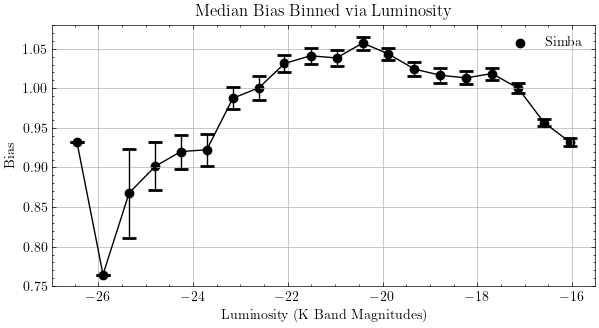

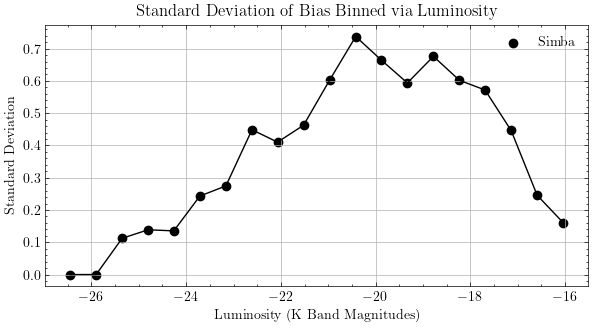

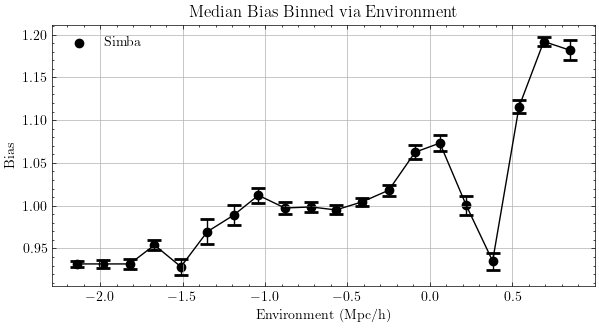

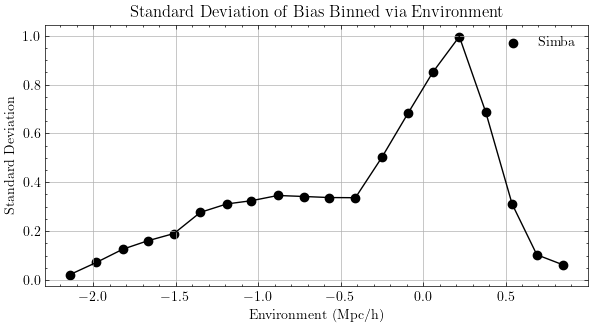

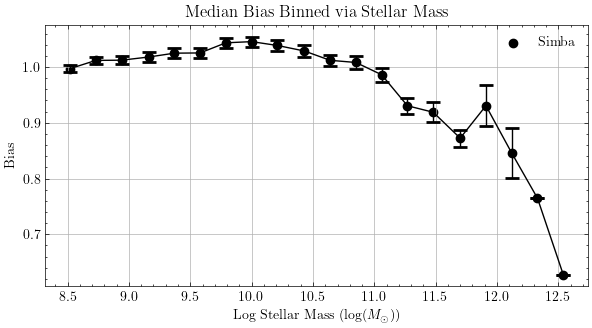

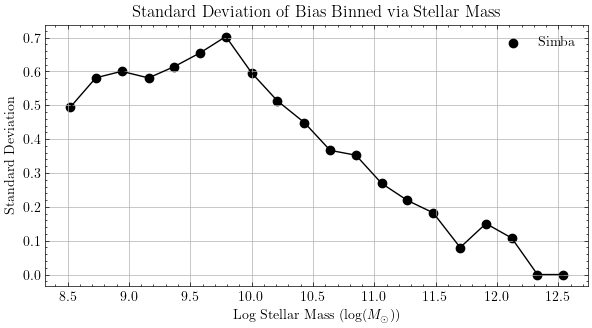

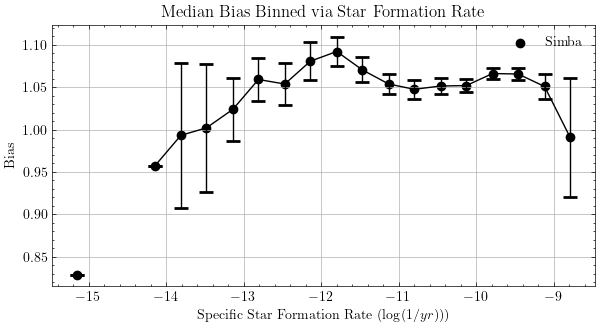

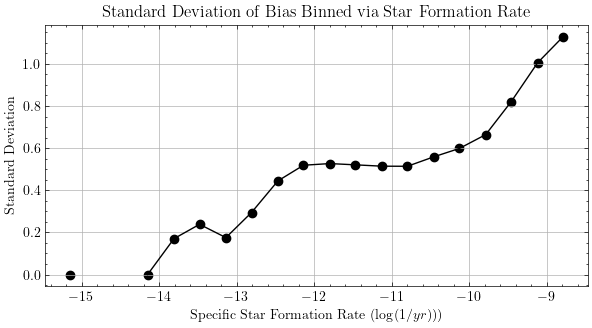

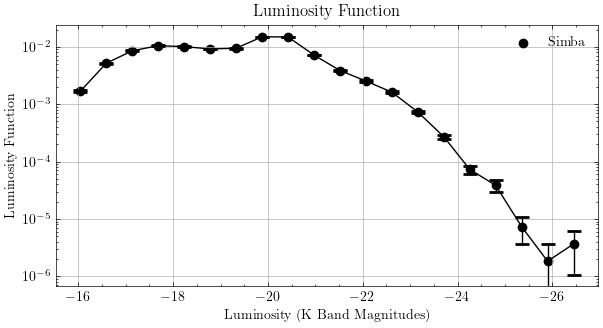

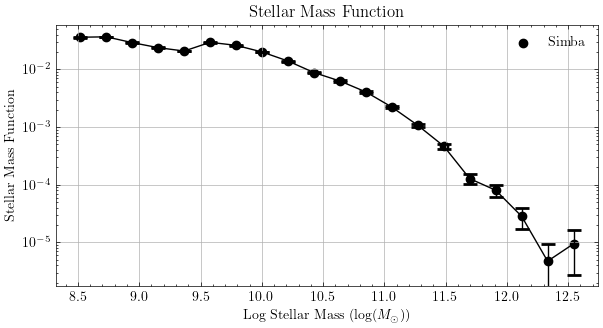

In [33]:
body(SMB,SMBPath1,SMBPath2,SMB_num,SMB_box,SMB_h,k_min,k_max,bin_num,saveplot)

/var/folders/xm/20hbpbkx48gfnxf0j2y0gxd40000gn/T/ipykernel_97591/3501950715.py:12: RuntimeWarning: divide by zero encountered in log10
  group_mas=np.log10(np.array(group['SubhaloMassType'][:,4])/h)+10 #Log(Msol)
/var/folders/xm/20hbpbkx48gfnxf0j2y0gxd40000gn/T/ipykernel_97591/3501950715.py:14: RuntimeWarning: divide by zero encountered in log10
  group_sfr=np.log10(np.array(group['SubhaloSFR']))-group_mas #Log(1/year)


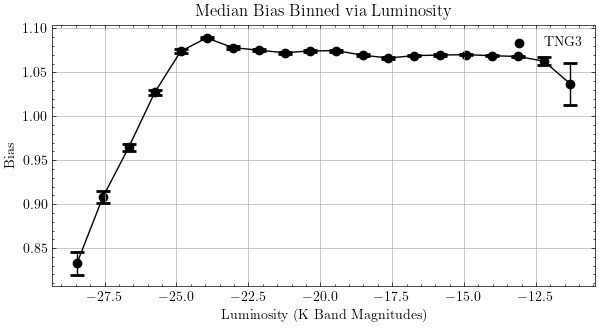

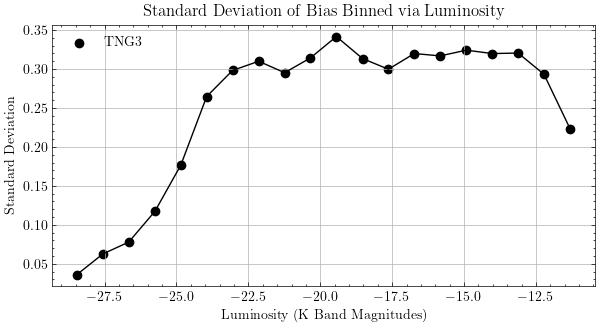

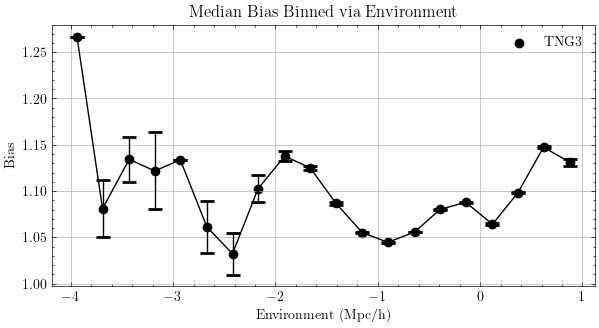

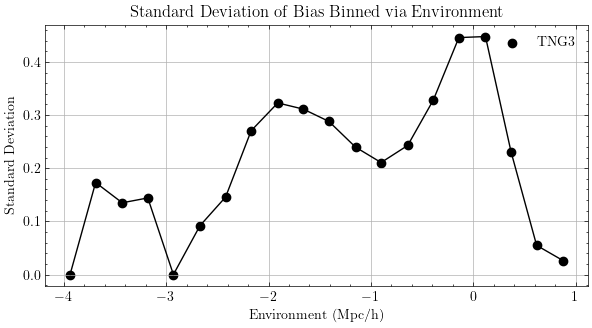

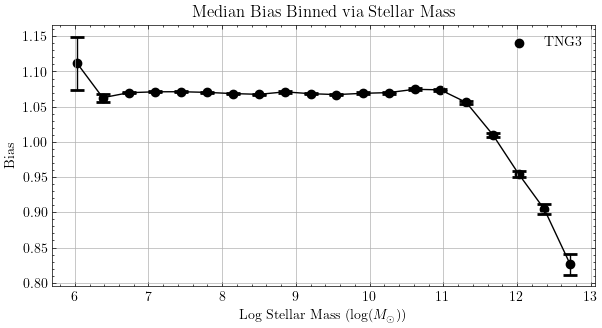

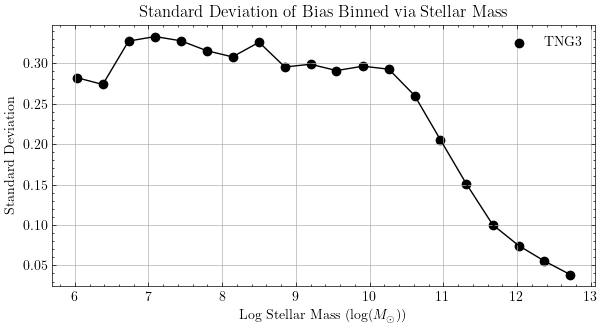

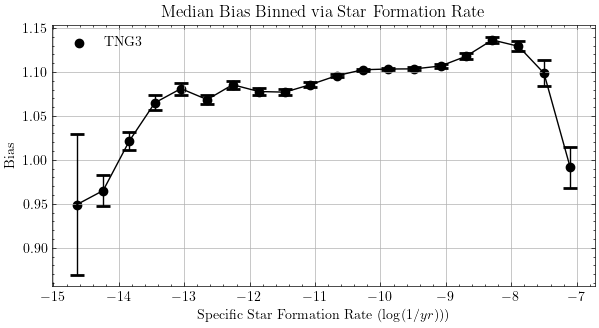

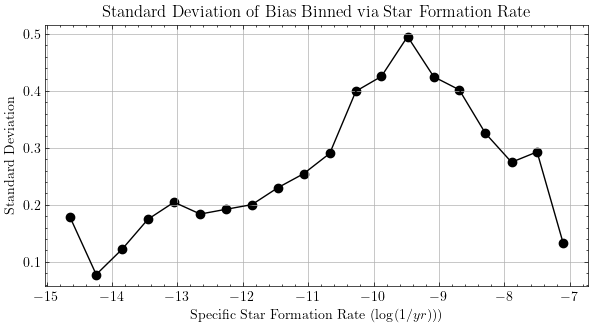

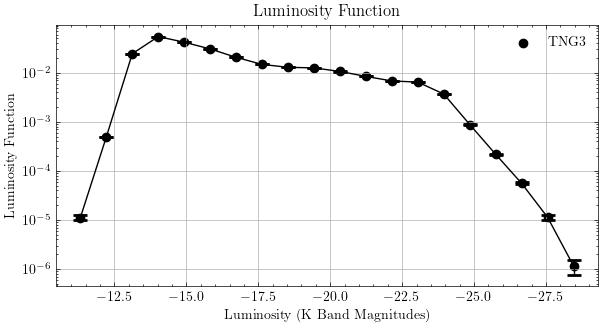

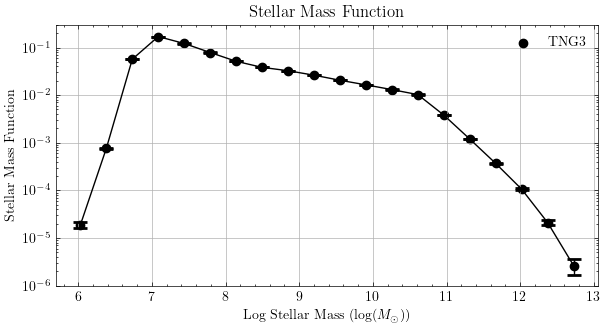

In [35]:
body(TN3,TN3Path1,TN3Path2,TN3_num,TN3_box,TN3_h,k_min,k_max,bin_num,saveplot)

In [ ]:
body(Ill,IllPath1,IllPath2,Ill_num,Ill_box,Ill_h,k_min,k_max,bin_num,saveplot)

/var/folders/xm/20hbpbkx48gfnxf0j2y0gxd40000gn/T/ipykernel_3964/3501950715.py:12: RuntimeWarning: divide by zero encountered in log10
  group_mas=np.log10(np.array(group['SubhaloMassType'][:,4])/h)+10 #Log(Msol)
/var/folders/xm/20hbpbkx48gfnxf0j2y0gxd40000gn/T/ipykernel_3964/3501950715.py:14: RuntimeWarning: divide by zero encountered in log10
  group_sfr=np.log10(np.array(group['SubhaloSFR']))-group_mas #Log(1/year)


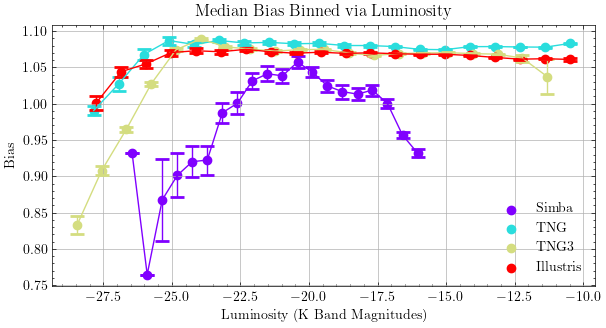

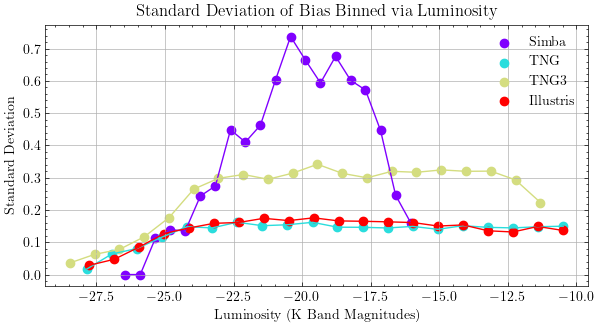

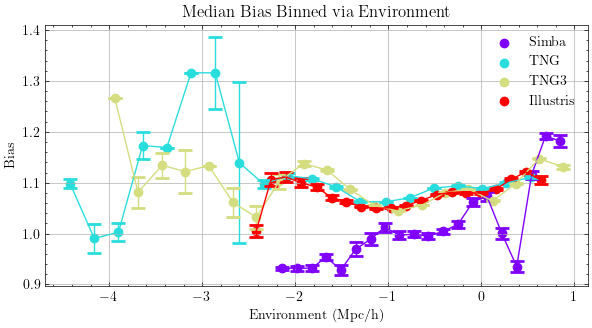

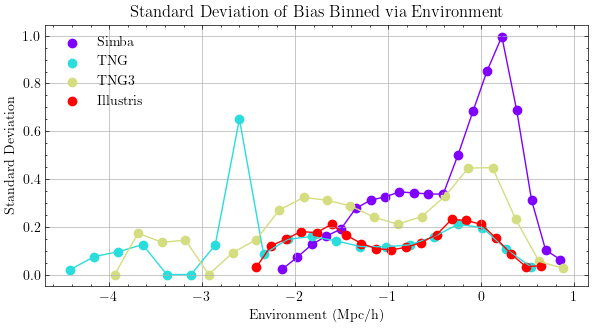

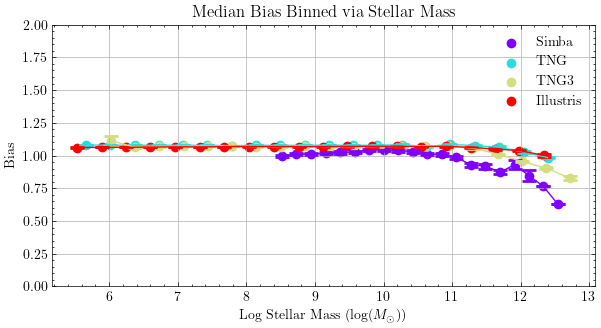

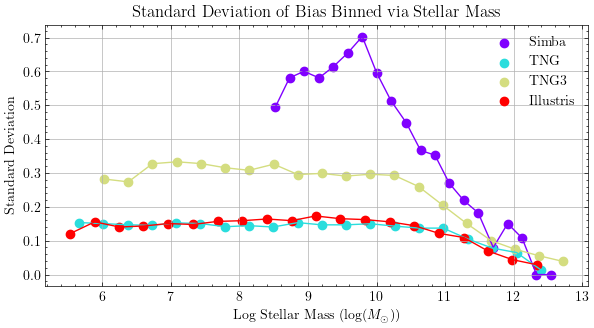

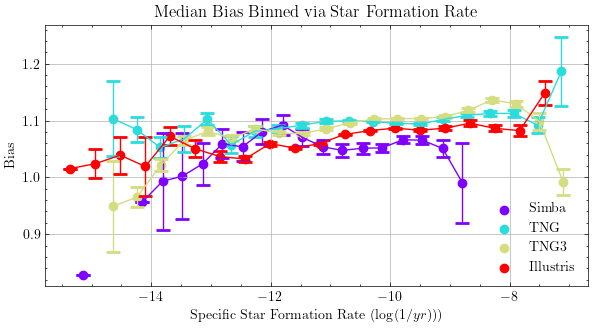

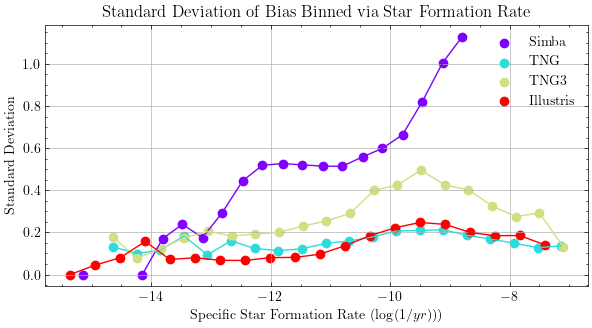

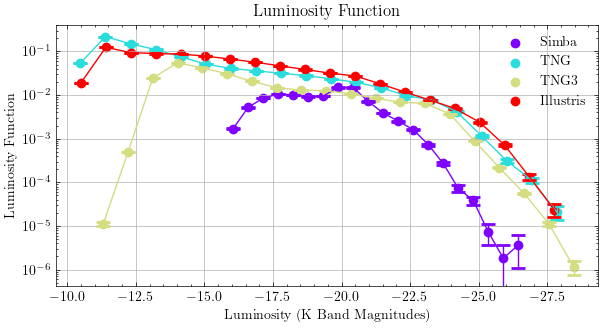

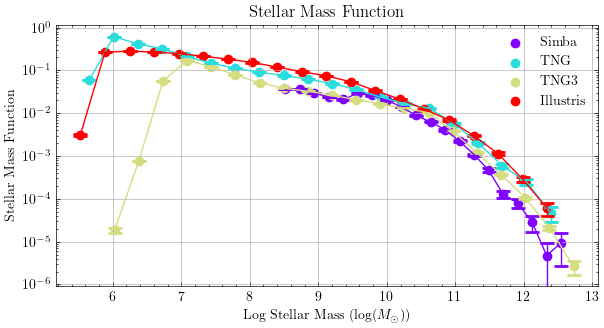

In [37]:
comblum(comp_lum_med_bin,comp_lum_med_bias,comp_lum_med_err,comp_lum_bias_std,comp_lum_std_err,comp,saveplot)
combenv(comp_env_med_bin,comp_env_med_bias,comp_env_med_err,comp_env_bias_std,comp_env_std_err,comp,saveplot)
combmas(comp_mas_med_bin,comp_mas_med_bias,comp_mas_med_err,comp_mas_bias_std,comp_mas_std_err,comp,saveplot)
combsfr(comp_sfr_med_bin,comp_sfr_med_bias,comp_sfr_med_err,comp_sfr_bias_std,comp_sfr_std_err,comp,saveplot)
comblfu(comp_lfu_med_bin,comp_lfu_med_bias,comp_lfu_med_err,comp,saveplot)
combmfu(comp_mfu_med_bin,comp_mfu_med_bias,comp_mfu_med_err,comp,saveplot)